In [242]:
import uproot
import numpy as np
import os

input_file = "data/atlas/data24_13p6TeV.root"
signal_path = "data/atlas/signal_clusters.npy"
noise_path = "data/atlas/noise_clusters.npy"
load = True  # Imposta a True per caricare i dati esistenti, False per estrarre nuovi dati

if os.path.exists(signal_path) and os.path.exists(noise_path) and load == True:
    # Carica i dati già salvati
    signal_clusters = np.load(signal_path, allow_pickle=True).tolist()
    noise_clusters = np.load(noise_path, allow_pickle=True).tolist()
    print("Dati caricati da file numpy.")
else:
    import uproot
    file = uproot.open(input_file)
    tree = file["BasicTesterTree;1"]
    num_events = 1000

    signal_clusters = []
    noise_clusters = []

    for i in range(num_events):
        event = tree.arrays([
            "PRD_MM_globalPosX",
            "PRD_MM_globalPosY",
            "PRD_MM_globalPosZ",
            "PRD_MM_stripCharges",
            "mmOnTrack_MuonLink",
            "muons_pt",
            "muons_author"
        ], entry_start=i, entry_stop=i+1, library="np")
        clusters_x = event["PRD_MM_globalPosX"][0]
        clusters_y = event["PRD_MM_globalPosY"][0]
        clusters_z = event["PRD_MM_globalPosZ"][0]
        clusters_charge = event["PRD_MM_stripCharges"][0]
        muon_links = event["mmOnTrack_MuonLink"][0]
        muons_pt = event["muons_pt"][0]
        muons_author = event["muons_author"][0]

        # Per ogni evento, salva separatamente i cluster di segnale e di rumore
        event_signal_clusters = []
        event_noise_clusters = []

        for i_mmOnTracks in range(len(muon_links)):
            muonLink = muon_links[i_mmOnTracks]
            is_signal = (
                muonLink < len(muons_pt)
                and muonLink < len(muons_author)
                and muons_pt[muonLink] >= 15
                and muons_author[muonLink] == 1
            )
            total_charge = np.sum(clusters_charge[i_mmOnTracks]) if hasattr(clusters_charge[i_mmOnTracks], "__iter__") and not isinstance(clusters_charge[i_mmOnTracks], (str, bytes)) else float(clusters_charge[i_mmOnTracks])
            cluster = {
                "x": clusters_x[i_mmOnTracks],
                "y": clusters_y[i_mmOnTracks],
                "z": clusters_z[i_mmOnTracks],
                "charge": total_charge,
                "muonLink": muonLink,
                "muon_pt": muons_pt[muonLink] if muonLink < len(muons_pt) else None,
                "muon_author": muons_author[muonLink] if muonLink < len(muons_author) else None
            }
            if is_signal:
                event_signal_clusters.append(cluster)
            else:
                event_noise_clusters.append(cluster)
        # Salva comunque la lista (anche se vuota) per mantenere la corrispondenza evento-cluster
        signal_clusters.append(event_signal_clusters)
        noise_clusters.append(event_noise_clusters)

    file.close()
    # Salva i dati in formato numpy
    np.save(signal_path, np.array(signal_clusters, dtype=object))
    np.save(noise_path, np.array(noise_clusters, dtype=object))
    print("Dati estratti e salvati in file numpy.")

Dati caricati da file numpy.


In [243]:
from sklearn.model_selection import train_test_split
import torch
from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors

# --- Crea un grafo per ogni evento ---
# Ogni nodo = un cluster (segnale o rumore), label nodo = 1 (segnale) o 0 (rumore)
# Il grafo rappresenta l'intero evento

event_graphs = []
num_events = min(len(signal_clusters), len(noise_clusters))
k = 2  # Numero di vicini per ogni nodo

for i in range(num_events):
    clusters = []
    labels = []
    # Unisci i cluster di segnale e rumore per l'evento
    for c in signal_clusters[i]:
        clusters.append([c["x"], c["y"], c["z"], c["charge"]])
        labels.append(1)
    for c in noise_clusters[i]:
        clusters.append([c["x"], c["y"], c["z"], c["charge"]])
        labels.append(0)
    if len(clusters) < 2:
        continue  # serve almeno 2 nodi per un grafo significativo
    x = torch.tensor(clusters, dtype=torch.float)  # [num_clusters, 4]
    y = torch.tensor(labels, dtype=torch.long)     # [num_clusters]
    N = x.shape[0]
    # Connessioni: solo ai k-nodi più vicini (sul solo spazio xyz)
    coords = np.array(clusters)[:, :3]  # solo x, y, z
    nbrs = NearestNeighbors(n_neighbors=min(k+1, N), algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)
    edge_index = []
    for idx, neighbors in enumerate(indices):
        for n in neighbors[1:]:  # salta se stesso (il primo vicino è il nodo stesso)
            edge_index.append([idx, n])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    event_graphs.append(Data(x=x, edge_index=edge_index, y=y))


print(f"Numero di eventi/grafi creati: {len(event_graphs)}")

# Split train/val/test a livello di evento
train_graphs, temp_graphs = train_test_split(event_graphs, test_size=0.4, random_state=42)
val_graphs, test_graphs = train_test_split(temp_graphs, test_size=0.5, random_state=42)
print(f"Train set: {len(train_graphs)} eventi, Validation set: {len(val_graphs)} eventi, Test set: {len(test_graphs)} eventi")

Numero di eventi/grafi creati: 412
Train set: 247 eventi, Validation set: 82 eventi, Test set: 83 eventi


In [244]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader

# --- Modello GNN per classificazione grafo ---
channels = 4  # x, y, z, charge
class GNN(nn.Module):
    def __init__(self, in_channels=channels, hidden_channels=64, out_channels=1, num_layers=3, dropout=0.2):
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers-1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.dropout = nn.Dropout(dropout)
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
            x = self.dropout(x)
        x = self.lin(x)
        return x.view(-1)

# --- Training e test ---
batch_size = 16*2
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=batch_size)
test_loader = DataLoader(test_graphs, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = GNN(hidden_channels = 16*4, out_channels = 1, num_layers = 2, dropout = 0.3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Calcola il rapporto tra classi
n_pos = sum([data.y.sum().item() for data in train_graphs])
n_total = sum([data.y.numel() for data in train_graphs])
n_neg = n_total - n_pos
pos_weight = torch.tensor([n_neg / n_pos]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        target = data.y.float().to(device)
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    avg_train_loss = total_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            out = model(data)
            target = data.y.float().to(device)
            loss = loss_fn(out, target)
            val_loss += loss.item() * data.num_graphs
    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs} - Train loss: {avg_train_loss:.4f} - Validation loss: {avg_val_loss:.4f}")

print("Training complete.")
# Test accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = torch.sigmoid(model(data))
        pred = (out > 0.5).long()
        correct += (pred == data.y.to(device)).sum().item()
        total += data.y.size(0)
print(f"Test accuracy: {correct/total:.2%}")

Using device: cuda
Epoch 1/20 - Train loss: 1716.0141 - Validation loss: 313.9519
Epoch 2/20 - Train loss: 1058.8330 - Validation loss: 487.7326
Epoch 3/20 - Train loss: 854.1089 - Validation loss: 262.1664
Epoch 4/20 - Train loss: 902.0679 - Validation loss: 54.8830
Epoch 5/20 - Train loss: 593.2062 - Validation loss: 30.4220
Epoch 6/20 - Train loss: 724.4942 - Validation loss: 41.0496
Epoch 7/20 - Train loss: 608.8882 - Validation loss: 157.6482
Epoch 8/20 - Train loss: 497.4594 - Validation loss: 35.9207
Epoch 9/20 - Train loss: 508.1690 - Validation loss: 44.4493
Epoch 10/20 - Train loss: 414.5583 - Validation loss: 23.2524
Epoch 11/20 - Train loss: 404.8882 - Validation loss: 29.0618
Epoch 12/20 - Train loss: 362.3348 - Validation loss: 55.2959
Epoch 13/20 - Train loss: 314.3289 - Validation loss: 21.6233
Epoch 14/20 - Train loss: 278.9778 - Validation loss: 47.8460
Epoch 15/20 - Train loss: 295.5047 - Validation loss: 11.8181
Epoch 16/20 - Train loss: 251.3849 - Validation loss: 

In [245]:
j=0

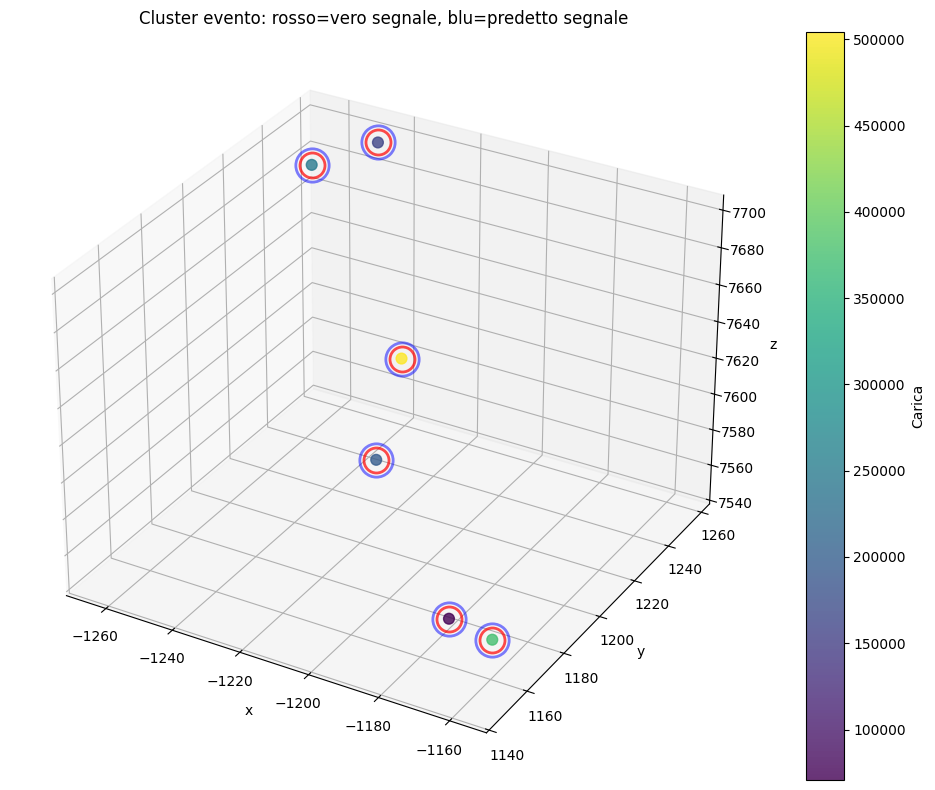

In [303]:
# --- Visualizzazione 3D dei cluster di un evento ---
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

j+=1

# Scegli un evento dal test set
data_es = test_graphs[j]
x = data_es.x.cpu().numpy()
charge = x[:, 3]
labels_true = data_es.y.cpu().numpy()

model.eval()
with torch.no_grad():
    out = torch.sigmoid(model(data_es.to(device)))
    pred_labels = (out.squeeze() > 0.5).cpu().numpy()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter dei cluster, colore = carica
p = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=charge, cmap='viridis', s=60, alpha=0.8)
fig.colorbar(p, ax=ax, label='Carica')

# Cerchio rosso attorno ai cluster di segnale (label vera)
for i in range(len(x)):
    if labels_true[i] == 1:
        ax.plot([x[i,0]], [x[i,1]], [x[i,2]], marker='o', markersize=18, markerfacecolor='none', markeredgecolor='red', markeredgewidth=2, alpha=0.7)

# Cerchio blu attorno ai cluster predetti come segnale dal modello
for i in range(len(x)):
    if pred_labels[i] == 1:
        ax.plot([x[i,0]], [x[i,1]], [x[i,2]], marker='o', markersize=24, markerfacecolor='none', markeredgecolor='blue', markeredgewidth=2, alpha=0.5)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Cluster evento: rosso=vero segnale, blu=predetto segnale')
plt.tight_layout()
plt.show()


In [185]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Parametri da esplorare
k_list = [2, 3, 4, 5, 6]
num_layers_list = [2, 3, 4, 5, 6]
results = []
epochs = 10
hidden_channels = 64

# Funzione per creare i grafi con k-nn
def build_graphs(signal_clusters, noise_clusters, k):
    event_graphs = []
    num_events = min(len(signal_clusters), len(noise_clusters))
    for i in range(num_events):
        clusters = []
        labels = []
        for c in signal_clusters[i]:
            clusters.append([c["x"], c["y"], c["z"], c["charge"]])
            labels.append(1)
        for c in noise_clusters[i]:
            clusters.append([c["x"], c["y"], c["z"], c["charge"]])
            labels.append(0)
        if len(clusters) < 2:
            continue
        x = torch.tensor(clusters, dtype=torch.float)
        y = torch.tensor(labels, dtype=torch.long)
        N = x.shape[0]
        coords = np.array(clusters)[:, :3]
        nbrs = NearestNeighbors(n_neighbors=min(k+1, N), algorithm='ball_tree').fit(coords)
        _, indices = nbrs.kneighbors(coords)
        edge_index = []
        for idx, neighbors in enumerate(indices):
            for n in neighbors[1:]:
                edge_index.append([idx, n])
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        event_graphs.append(Data(x=x, edge_index=edge_index, y=y))
    return event_graphs

# Definizione modello GNN
class GNN(nn.Module):
    def __init__(self, in_channels=4, hidden_channels=32, out_channels=1, num_layers=2, dropout=0.2):
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers-1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.dropout = nn.Dropout(dropout)
        self.lin = nn.Linear(hidden_channels, out_channels)
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
            x = self.dropout(x)
        x = self.lin(x)
        return x.view(-1)

# Grid search
for k in k_list:
    for num_layers in num_layers_list:
        print(f"\n--- Training: k={k}, num_layers={num_layers} ---")
        # Crea i grafi
        event_graphs = build_graphs(signal_clusters, noise_clusters, k)
        train_graphs, temp_graphs = train_test_split(event_graphs, test_size=0.4, random_state=42)
        val_graphs, test_graphs = train_test_split(temp_graphs, test_size=0.5, random_state=42)
        train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_graphs, batch_size=16)
        test_loader = DataLoader(test_graphs, batch_size=16)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = GNN(hidden_channels=hidden_channels, out_channels=1, num_layers=num_layers, dropout=0.2).to(device)
        # Calcola pos_weight per la loss
        n_pos = sum([data.y.sum().item() for data in train_graphs])
        n_total = sum([data.y.numel() for data in train_graphs])
        n_neg = n_total - n_pos
        pos_weight = torch.tensor([n_neg / n_pos]).to(device)
        loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
        # Training breve (pochi epoch per rapidità)
        best_val_loss = float('inf')
        best_test_acc = 0
        for epoch in range(epochs):
            model.train()
            for data in train_loader:
                data = data.to(device)
                optimizer.zero_grad()
                out = model(data)
                target = data.y.float().to(device)
                loss = loss_fn(out, target)
                loss.backward()
                optimizer.step()
            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for data in val_loader:
                    data = data.to(device)
                    out = model(data)
                    target = data.y.float().to(device)
                    loss = loss_fn(out, target)
                    val_loss += loss.item() * data.num_graphs
            avg_val_loss = val_loss / len(val_loader.dataset)
            if avg_val_loss < best_val_loss:
                # Test accuracy
                correct = 0
                total = 0
                with torch.no_grad():
                    for data in test_loader:
                        data = data.to(device)
                        out = torch.sigmoid(model(data))
                        pred = (out > 0.5).long()
                        correct += (pred == data.y.to(device)).sum().item()
                        total += data.y.size(0)
                best_val_loss = avg_val_loss
                best_test_acc = correct / total if total > 0 else 0
                best_model = model
        print(f"Best test accuracy: {best_test_acc:.2%}")
        results.append({'k': k, 'num_layers': num_layers, 'test_acc': best_test_acc})

# Riassunto risultati
print("\n--- RISULTATI GRID SEARCH ---")
for r in results:
    print(f"k={r['k']}, num_layers={r['num_layers']}, test_acc={r['test_acc']:.2%}")

# Trova la combinazione migliore
best = max(results, key=lambda r: r['test_acc'])
print(f"\nMiglior combinazione: k={best['k']}, num_layers={best['num_layers']}, test_acc={best['test_acc']:.2%}")



--- Training: k=2, num_layers=2 ---
Best test accuracy: 79.08%

--- Training: k=2, num_layers=3 ---
Best test accuracy: 49.09%

--- Training: k=2, num_layers=4 ---
Best test accuracy: 59.80%

--- Training: k=2, num_layers=5 ---
Best test accuracy: 57.66%

--- Training: k=2, num_layers=6 ---
Best test accuracy: 57.50%

--- Training: k=3, num_layers=2 ---
Best test accuracy: 79.74%

--- Training: k=3, num_layers=3 ---
Best test accuracy: 65.07%

--- Training: k=3, num_layers=4 ---
Best test accuracy: 87.48%

--- Training: k=3, num_layers=5 ---
Best test accuracy: 9.56%

--- Training: k=3, num_layers=6 ---
Best test accuracy: 80.23%

--- Training: k=4, num_layers=2 ---
Best test accuracy: 64.58%

--- Training: k=4, num_layers=3 ---
Best test accuracy: 37.07%

--- Training: k=4, num_layers=4 ---
Best test accuracy: 10.87%

--- Training: k=4, num_layers=5 ---
Best test accuracy: 85.67%

--- Training: k=4, num_layers=6 ---
Best test accuracy: 21.42%

--- Training: k=5, num_layers=2 ---
Best